In [12]:
import os
import numpy as np 
import surveysim.stats
from astropy.io import fits
from astropy.time import Time

# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [13]:
_dir = '/global/cscratch1/sd/chahah/desisurvey_output'

In [14]:
texp = 170
footprint = 14000
twilight = False
version = 6
#_file = '%is_bgs%i_skybranch_v%i%s.brightsky.bgs%i' % (texp, footprint, version, ['', '.twilight'][twilight], footprint)
#_file = '%is_bgs%i_skybranch_v%i%s.brightsky' % (texp, footprint, version, ['', '.twilight'][twilight])
_file = '%is_bgs%i_skybranch_v%i%s.brightsky.deepfirst' % (texp, footprint, version, ['', '.twilight'][twilight])

fstats = os.path.join(_dir, 'stats_%s.fits' % _file)
#stats = surveysim.stats.SurveyStatistics(restore=fstats, bgs_footprint=footprint)
stats = surveysim.stats.SurveyStatistics(restore=fstats, bgs_footprint=None)

fexps = os.path.join(_dir, 'exposures_%s.fits' % _file)
exps = fits.getdata(fexps, 'exposures')

(16071,)
INFO:stats.py:79:__init__: Restored stats from /global/cscratch1/sd/chahah/desisurvey_output/stats_170s_bgs14000_skybranch_v6.brightsky.fits
INFO:stats.py:81:__init__:   Comment: "".


In [28]:
def surveysim_summary(texp, footprint, version=6, deepfirst=False, twilight=False):

    _file = ('%is_bgs%i_skybranch_v%i%s.brightsky%s%s' % 
             (texp, footprint, version, ['', '.twilight'][twilight], ['.bgs%i' % footprint, ''][footprint == 14000], ['', '.deepfirst'][deepfirst]))


    fstats = os.path.join(_dir, 'stats_%s.fits' % _file)
    stats = surveysim.stats.SurveyStatistics(restore=fstats, bgs_footprint=[footprint, None][footprint == 14000])

    fexps = os.path.join(_dir, 'exposures_%s.fits' % _file)
    exps = fits.getdata(fexps, 'exposures')
    
    stats.summarize()
    
    actual = np.cumsum(stats._data['completed'], axis=0)

    third_pass = stats.tiles.program_passes['BRIGHT'][-1]
    npass = stats.tiles.pass_ntiles[third_pass]
    passidx = stats.tiles.pass_index[third_pass]
    bgs_complete = (actual[:,passidx] / npass) == 1.

    dt = 1 + np.arange(len(stats._data))
    print('BGS finishes 3rd passs on day %i of %i' % (dt[bgs_complete].min(), dt[-1]))
    print('  %.1f percent margin' % (100.*(dt[-1] - dt[bgs_complete].min())/dt[-1]))
    
    fig, sub = stats.plot()
    
    # get BGS tiles
    _pass = np.zeros(len(stats.tiles.passnum)).astype(bool)
    for i in range(3):
        _pass = _pass | (stats.tiles.passnum == stats.tiles.program_passes['BRIGHT'][i-3])

    tileid_pass = stats.tiles.tileID[_pass]
    _, m0, m1 = np.intersect1d(exps['TILEID'], tileid_pass, return_indices=True)
    
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)

    sub.scatter(((stats.tiles.tileRA[_pass] - 80) % 360) + 80, stats.tiles.tileDEC[_pass], s=5, c='k')
    sub.set_xlim(80, 440)
    sub.set_ylabel('Dec', fontsize=25)
    sub.set_ylim(-25., 90.)
    sub.set_xlabel('RA', fontsize=25)
    
    t_exps = Time(exps['MJD'], format='mjd')
    
    fig = plt.figure(figsize=(25, 12))
    for year in range(5): 
        inyear = (t_exps[m0].decimalyear >= t_exps.decimalyear.min() + year) & (t_exps[m0].decimalyear < t_exps.decimalyear.min() + year + 1)

        sub = fig.add_subplot(2,3,year+1)
        sub.scatter(((stats.tiles.tileRA[_pass][m1][inyear] - 80) % 360) + 80, stats.tiles.tileDEC[_pass][m1][inyear], s=5, c='k')
        sub.set_xlim(80, 440)
        if year in [0, 3]: sub.set_ylabel('Dec', fontsize=25)
        sub.set_ylim(-25., 90.)
        sub.text(0.95, 0.95, 'year %i' % (year+1), transform=sub.transAxes, ha='right', va='top', fontsize=20)
    sub.set_xlabel('RA', fontsize=25)
    
    fig = plt.figure(figsize=(6,6))
    sub = fig.add_subplot(111)
    sub.hist(exps['SKY'][m0], range=(0., 20), bins=50)
    sub.plot([2.5, 2.5], [0., 750], c='k', ls='--')
    sub.text(0.95, 0.95, 'median=%.2f' %np.median(exps['SKY'][m0]), transform=sub.transAxes, ha='right', va='top', fontsize=20)
    sub.set_xlabel('sky brightness exposure factor', fontsize=25)
    sub.set_xlim(0., 20)

(16071,)
INFO:stats.py:79:__init__: Restored stats from /global/cscratch1/sd/chahah/desisurvey_output/stats_170s_bgs14000_skybranch_v6.brightsky.fits
INFO:stats.py:81:__init__:   Comment: "".
Scheduled 10556.714 hr Open 74.933% Live 74.774%
PROG PASS    TILES  NEXP SETUP ABT SPLIT ABT    TEXP TSETUP TSPLIT   TOPEN  TDEAD
DARK   0 2010/2010  6089  3041  19  3048  12 1864.4s 182.1s  91.1s
DARK   1 2011/2011  6004  2955  14  3049   9 1857.0s 176.8s  91.1s
DARK   2 2007/2007  5885  2884  12  3001   6 1868.5s 172.9s  89.8s
DARK   3 2010/2010  6177  3000  11  3177   9 2037.8s 179.3s  95.0s
DARK     8038/8038 24155 11880  56 12275  36 1906.9s 177.8s  91.8s 2296.7s 120.2s
----------------------------------------------------------------------------------
GRAY   4 2005/2005  6119  3136  29  2983   9 1844.8s 188.4s  89.4s
GRAY     2005/2005  6119  3136  29  2983   9 1844.8s 188.4s  89.4s 2331.6s 209.1s
----------------------------------------------------------------------------------
BRIGHT 5 200

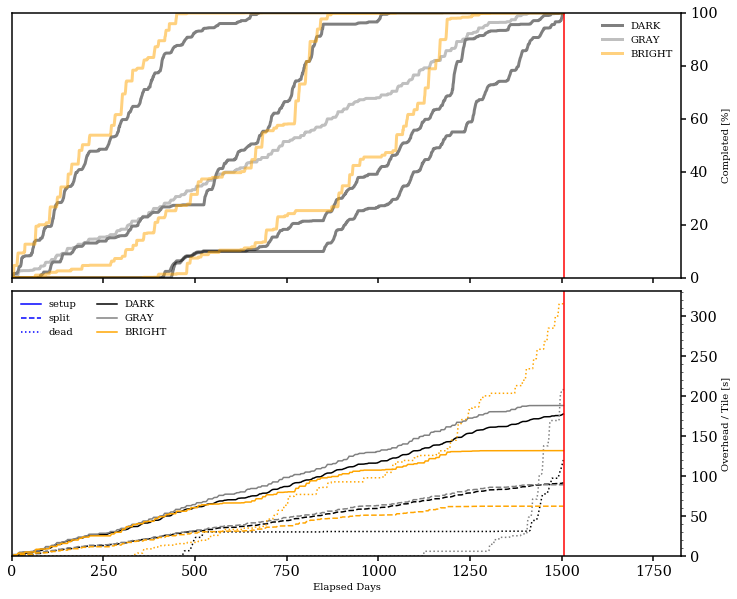

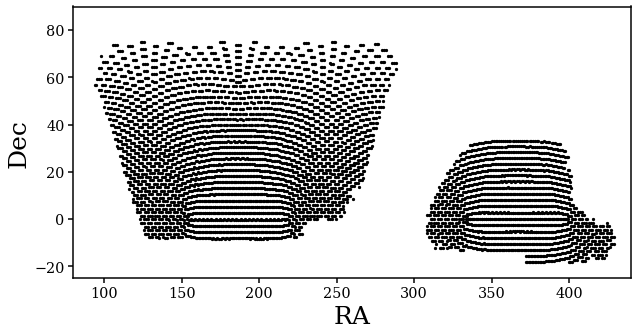

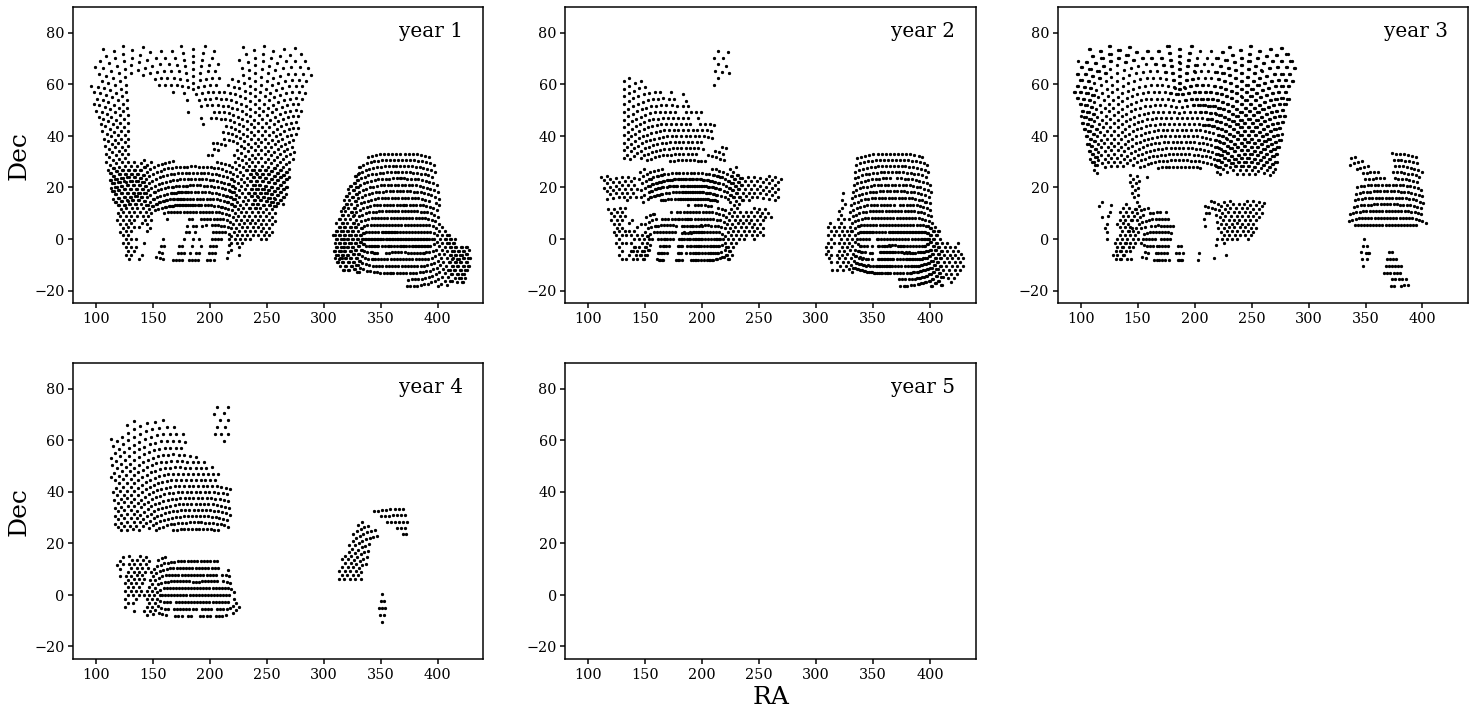

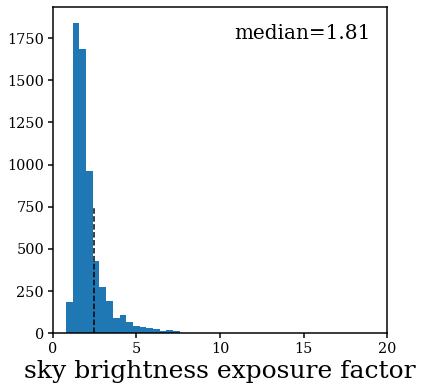

In [29]:
surveysim_summary(170, 14000, version=6, deepfirst=False, twilight=False)

(16071,)
INFO:stats.py:79:__init__: Restored stats from /global/cscratch1/sd/chahah/desisurvey_output/stats_170s_bgs14000_skybranch_v6.brightsky.deepfirst.fits
INFO:stats.py:81:__init__:   Comment: "".
Scheduled 10385.059 hr Open 74.688% Live 75.932%
PROG PASS    TILES  NEXP SETUP ABT SPLIT ABT    TEXP TSETUP TSPLIT   TOPEN  TDEAD
DARK   0 2010/2010  5934  2870   6  3064   7 1881.8s 171.4s  91.5s
DARK   1 2011/2011  5792  2806  14  2986   6 1873.7s 167.9s  89.2s
DARK   2 2007/2007  6032  3014  30  3018  11 1901.0s 181.1s  90.4s
DARK   3 2010/2010  6111  3041  21  3070  10 1949.7s 182.2s  91.8s
DARK     8038/8038 23869 11731  71 12138  34 1901.6s 175.7s  90.7s 2249.0s  81.0s
----------------------------------------------------------------------------------
GRAY   4 2005/2005  6163  3156  11  3007  11 1838.7s 189.1s  90.1s
GRAY     2005/2005  6163  3156  11  3007  11 1838.7s 189.1s  90.1s 2292.2s 174.2s
----------------------------------------------------------------------------------
BR

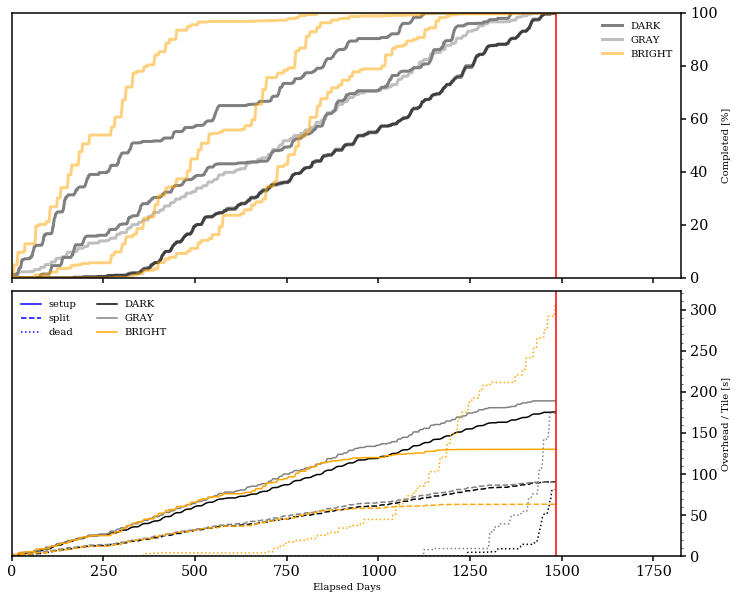

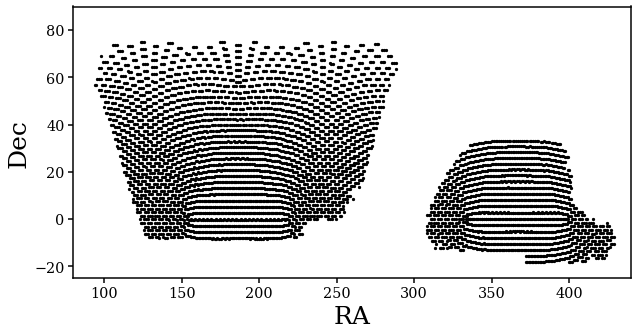

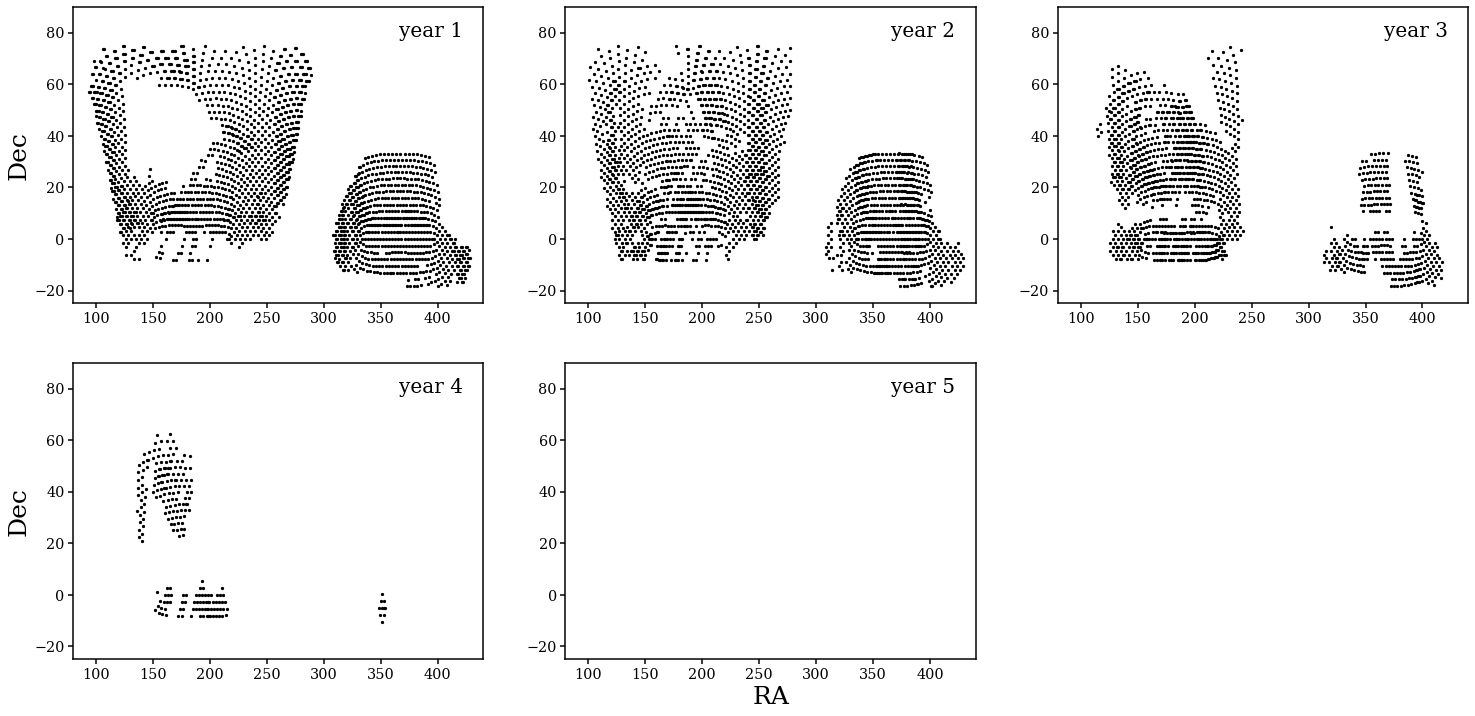

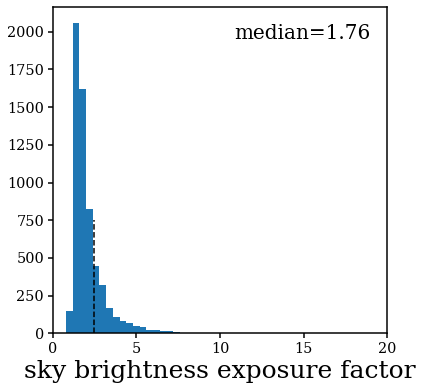

In [30]:
surveysim_summary(170, 14000, version=6, deepfirst=True, twilight=False)

(16071,)
INFO:stats.py:79:__init__: Restored stats from /global/cscratch1/sd/chahah/desisurvey_output/stats_180s_bgs14000_skybranch_v6.brightsky.fits
INFO:stats.py:81:__init__:   Comment: "".
Scheduled 10556.714 hr Open 74.925% Live 75.742%
PROG PASS    TILES  NEXP SETUP ABT SPLIT ABT    TEXP TSETUP TSPLIT   TOPEN  TDEAD
DARK   0 2010/2010  6061  3007  20  3054  10 1867.5s 180.0s  91.3s
DARK   1 2011/2011  5956  2923  13  3033   3 1845.4s 174.9s  90.6s
DARK   2 2007/2007  6108  2985  14  3123  11 1942.8s 178.9s  93.5s
DARK   3 2010/2010  6089  2970   4  3119  12 1993.5s 177.4s  93.2s
DARK     8038/8038 24214 11885  51 12329  36 1912.3s 177.8s  92.1s 2296.3s 114.0s
----------------------------------------------------------------------------------
GRAY   4 2005/2005  6167  3182  22  2985  10 1847.1s 191.1s  89.5s
GRAY     2005/2005  6167  3182  22  2985  10 1847.1s 191.1s  89.5s 2331.6s 204.0s
----------------------------------------------------------------------------------
BRIGHT 5 200

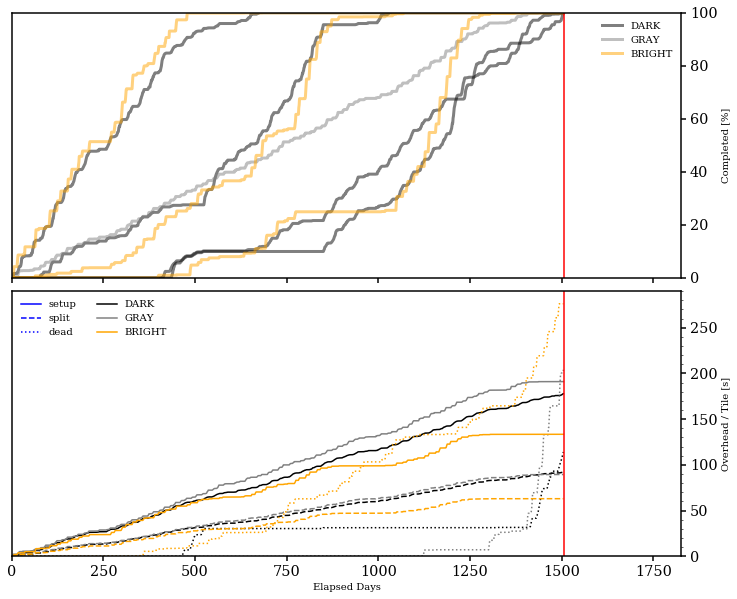

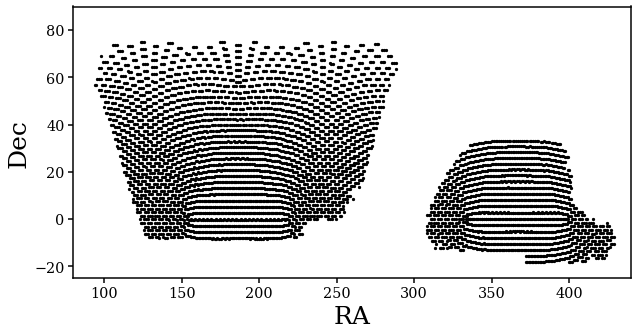

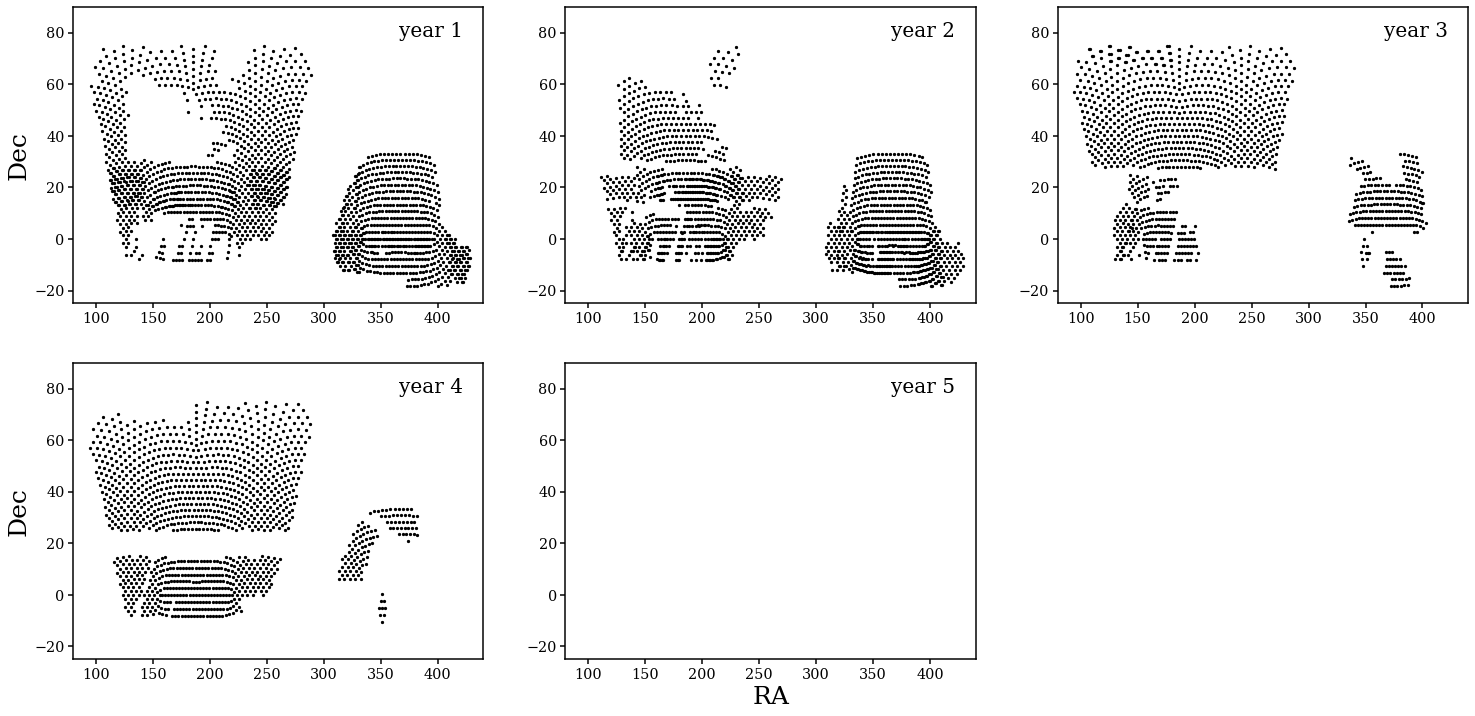

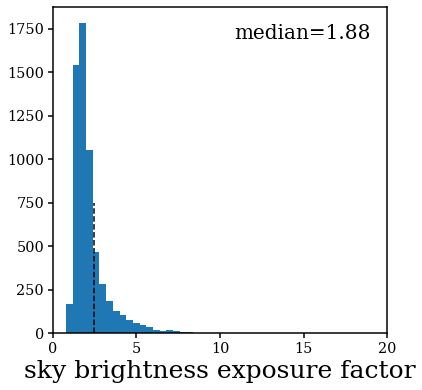

In [32]:
surveysim_summary(180, 14000, version=6, deepfirst=False, twilight=False)

(16071,)
INFO:stats.py:79:__init__: Restored stats from /global/cscratch1/sd/chahah/desisurvey_output/stats_180s_bgs14000_skybranch_v6.brightsky.deepfirst.fits
INFO:stats.py:81:__init__:   Comment: "".
Scheduled 10269.815 hr Open 75.168% Live 76.963%
PROG PASS    TILES  NEXP SETUP ABT SPLIT ABT    TEXP TSETUP TSPLIT   TOPEN  TDEAD
DARK   0 2010/2010  5868  2849  10  3019   7 1862.3s 170.3s  90.2s
DARK   1 2011/2011  5762  2830  16  2932   2 1860.0s 169.4s  87.5s
DARK   2 2007/2007  6227  3093  17  3134   5 1968.4s 185.5s  93.7s
DARK   3 2010/2010  6046  2997  15  3049   6 1906.8s 179.4s  91.1s
DARK     8038/8038 23903 11769  58 12134  20 1899.4s 176.1s  90.6s 2243.8s  77.7s
----------------------------------------------------------------------------------
GRAY   4 2005/2005  6166  3139  12  3027  10 1836.9s 188.2s  90.8s
GRAY     2005/2005  6166  3139  12  3027  10 1836.9s 188.2s  90.8s 2292.2s 176.3s
----------------------------------------------------------------------------------
BR

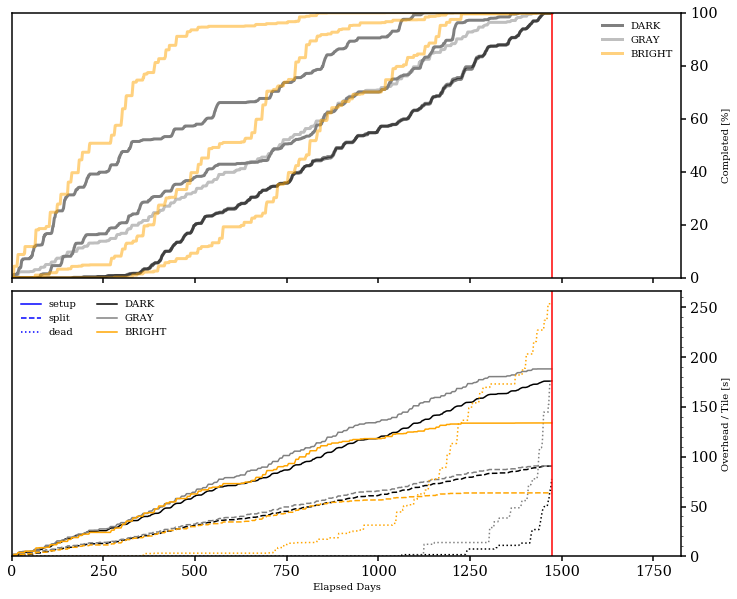

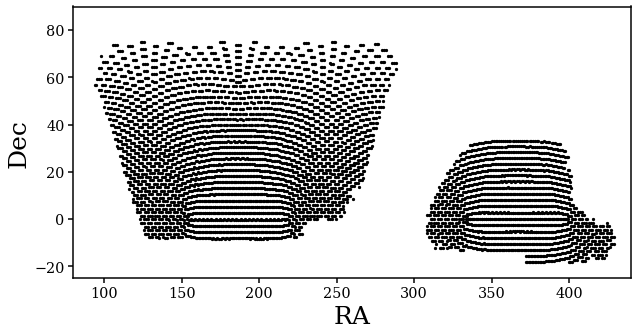

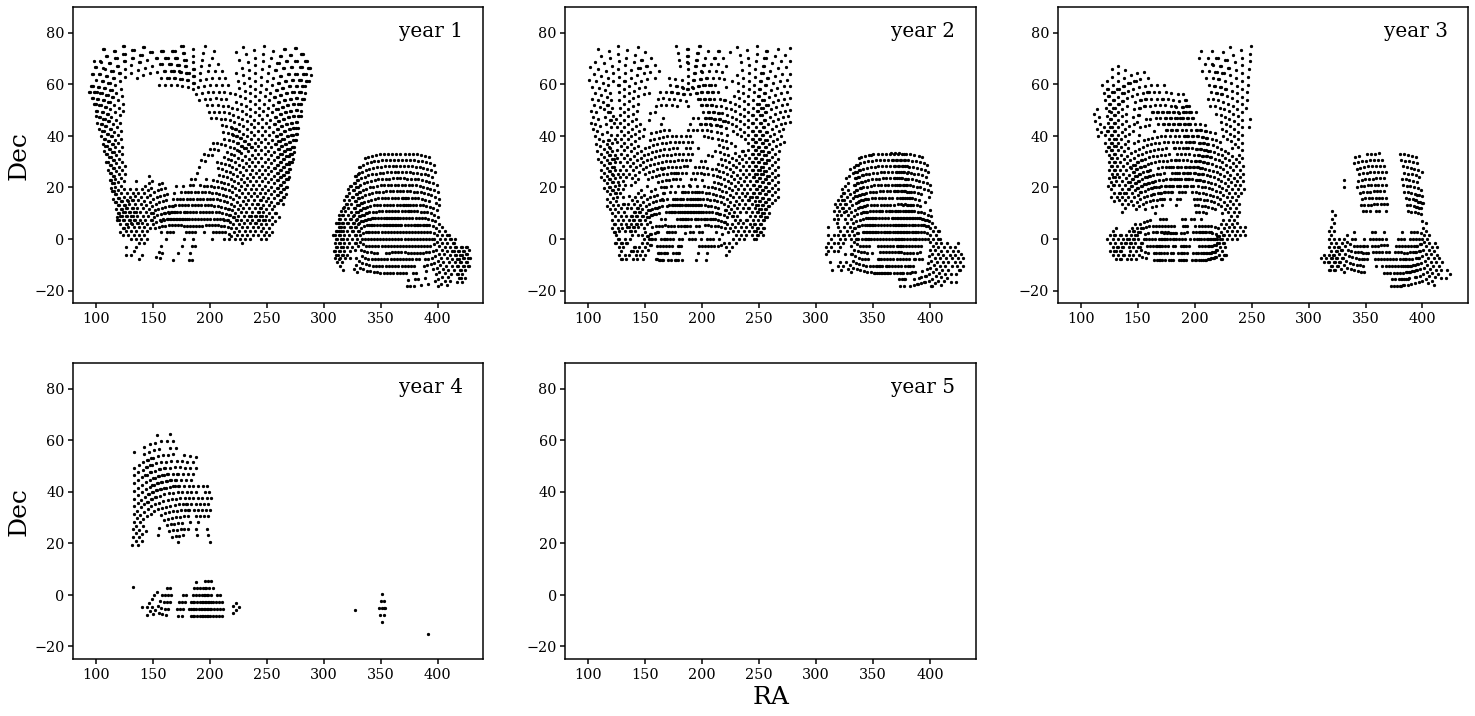

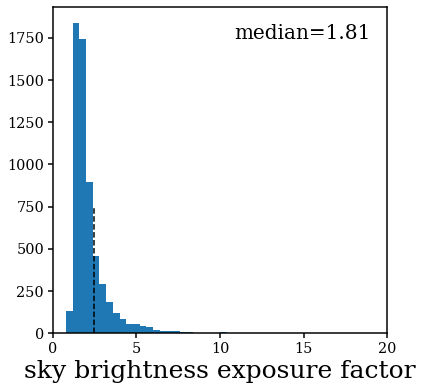

In [33]:
surveysim_summary(180, 14000, version=6, deepfirst=True, twilight=False)